<a href="https://colab.research.google.com/github/arybinski/xai-notebooks/blob/master/SemanticDictionaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Install / Import / Load

This code depends on [Lucid](https://github.com/tensorflow/lucid) (our visualization library), and [svelte](https://svelte.technology/) (a web framework). The following cell will install both of them, and dependancies such as TensorFlow. And then import them as appropriate.

In [2]:
!pip install --quiet lucid==0.0.5
!npm install -g svelte-cli@2.2.0

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
import lucid.optvis.render as render
from lucid.misc.io import show, load
from lucid.misc.io.showing import _image_url
import lucid.scratch.web.svelte as lucid_svelte

/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
added 2 packages from 1 contributor in 1.572s


In [3]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_M3gVbD/SemanticDict_2e4bb76.html > /tmp/svelte_M3gVbD/SemanticDict_2e4bb76.js


W0908 08:17:03.513000 140341762205568 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/reading.py:119: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



svelte version 1.64.1
compiling ../tmp/svelte_M3gVbD/SemanticDict_2e4bb76.html...



In [0]:
layer_spritemap_sizes = {
    'mixed3a' : 16,
    'mixed3b' : 21,
    'mixed4a' : 22,
    'mixed4b' : 22,
    'mixed4c' : 22,
    'mixed4d' : 22,
    'mixed4e' : 28,
    'mixed5a' : 28,
  }

def googlenet_spritemap(layer):
  assert layer in layer_spritemap_sizes
  size = layer_spritemap_sizes[layer]
  url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_%s_channel_alpha.jpeg" % layer
  return size, url

In [5]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()


def googlenet_semantic_dict(layer, img_url):
    img = load(img_url)
    
    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, [224, 224, 3])
        T = render.import_model(googlenet, t_input, t_input)
        acts = T(layer).eval({t_input: img})[0]
    
    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = googlenet_spritemap(layer)
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": 110,
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img),
        "activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:4]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [max_y, max_x]
    })

W0908 08:17:03.929126 140341762205568 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0908 08:17:05.819788 140341762205568 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/util.py:29: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.



# Semantic dictionaries


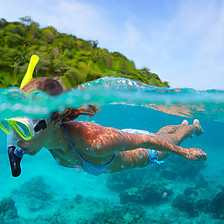

In [12]:
googlenet_semantic_dict("mixed4d", "https://static.wixstatic.com/media/7c5efc_99e4ea5fe2a449bb9c73199669696d0f~mv2.jpg/v1/fill/w_224,h_224,fp_0.50_0.50,q_90,usm_0.66_1.00_0.01/7c5efc_99e4ea5fe2a449bb9c73199669696d0f~mv2.jpg")